In [21]:
import re
import time
from string import punctuation

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.manifold import TSNE

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Sequence, BertPreTokenizer, Punctuation
from tokenizers.normalizers import Lowercase, Normalizer
from tokenizers.trainers import WordLevelTrainer

from navec import Navec
from slovnet.model.emb import NavecEmbedding

# Data Processing

In [2]:
data = pd.read_csv('data/lenta_news.csv')

data.head()

,title,text,topic
0,МВД создало бюро по борьбе с отмыванием денег,В МВД России создано оперативно-розыскное бюро...,Экономика
1,Правительство не будет занимать деньги у ЦБ,Правительство не будет прибегать к заимствован...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Компания Boeing получит пятилетний контракт на...,Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Результаты конкурса на право освоения месторож...,Экономика
4,Неимущим для получения пособия придется расста...,В доходах малоимущих россиян будут учитываться...,Экономика


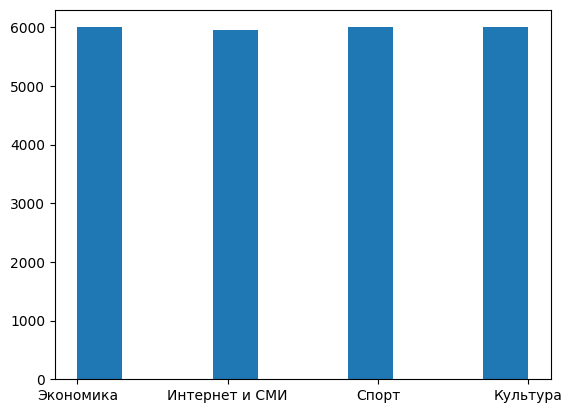

In [12]:
plt.hist(data['topic'])
plt.show()

In [3]:
X, y = data.text, data.topic
y = pd.Categorical(y)

X = X.map(lambda a: re.sub(r'\d', '', a))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [4]:
model = WordLevel(unk_token='<UNK>')

tokenizer = Tokenizer(model)
tokenizer.pre_tokenizer = Sequence([BertPreTokenizer(), Punctuation(behavior='removed')])
tokenizer.normalizer = Lowercase()
tokenizer.enable_padding(direction='right', pad_id=0, pad_token='<PAD>', max_length=256)
tokenizer.enable_truncation(max_length=256)

trainer = WordLevelTrainer(special_tokens=['<PAD>', '<UNK>', '<SOS>', '<EOS>'])

tokenizer.train_from_iterator(X_train, trainer=trainer)

In [5]:
tokenizer.get_vocab_size()

30000

In [6]:
class NewsDataset():
    def __init__(self, data, label_col, tokenizer, encode_labels=False):
        self.data = data
        self.tokenizer = tokenizer

        if encode_labels:
            self.labels = pd.Categorical(self.data[label_col]).categories
            self.data[label_col] = pd.Categorical(self.data[label_col]).codes
        else:
            self.labels = self.data[label_col].unique()
        
    def __getitem__(self, idx):
        text, label = self.data.iloc[idx, :]
        encoded = torch.tensor(self.tokenizer.encode(text).ids)

        return encoded, label

    def __len__(self):
        return len(self.data)

In [7]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
test_data = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = NewsDataset(train_data, 'label', tokenizer, encode_labels=True)
test_dataset = NewsDataset(test_data, 'label', tokenizer, encode_labels=True)

In [8]:
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size=64), DataLoader(test_dataset, batch_size=64)

# Training

In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [13]:
class TopicClassifier(nn.Module):
    def __init__(self, size_vocab, dim, n_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=size_vocab,
                                      embedding_dim=dim)
        self.classifier = nn.Sequential(nn.Linear(dim, 128), 
                                        nn.ReLU(), 
                                        nn.Linear(128, 64), 
                                        nn.ReLU(),
                                        nn.Linear(64, n_classes))

    def forward(self, X):
        embeds = self.embedding(X)
        embeds = embeds.mean(axis=1)
        
        out = self.classifier(embeds)

        return out

In [14]:
def train_loop(dataloader, model, loss, optimizer, report=False, verbose=False):
    model.train()
    train_loss = 0
    
    train_pred = []
    ground_truth = []

    for ind, (text, label) in enumerate(dataloader):
        text, label = text.to(DEVICE), label.long().to(DEVICE)

        pred_logits = model(text)
        batch_loss = loss(pred_logits, label)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.item()

        pred_labels = pred_logits.argmax(axis=1)
        train_pred.extend(pred_labels.tolist())
        ground_truth.extend(label.flatten().tolist())

        if verbose and ind % verbose == 0:
            print(f'Loss: {round(batch_loss.item(), 5)}\t [{ind*len(text)}/{len(dataloader.dataset)}]')

    train_loss /= len(dataloader)
    train_f1 = f1_score(train_pred, ground_truth, average='macro')

    if verbose:
        print(f'Train Loss: {round(train_loss, 5)}\tTrain F1: {round(train_f1, 5)}')

    if report:
        print(classification_report(train_pred, ground_truth))

    return train_loss, train_f1

In [15]:
def test_loop(dataloader, model, loss, report=False, verbose=False):
    model.eval()
    test_loss = 0
    test_f1 = 0
    
    test_pred = []
    ground_truth = []

    with torch.no_grad():
        for ind, (text, label) in enumerate(dataloader):
            text, label = text.to(DEVICE), label.long().to(DEVICE)
    
            pred_logits = model(text)
            batch_loss = loss(pred_logits, label)
    
            test_loss += batch_loss.item()
    
            pred_labels = pred_logits.argmax(axis=1)
            test_pred.extend(pred_labels.tolist())
            ground_truth.extend(label.flatten().tolist())

    test_loss /= len(dataloader)
    test_f1 = f1_score(test_pred, ground_truth, average='macro')

    if verbose:
        print(f'Test Loss: {round(test_loss, 5)}\tTest F1: {round(test_f1, 5)}\n')

    if report:
        print(classification_report(test_pred, ground_truth))

    return test_loss, test_f1

## Navec embeddings

In [27]:
path = 'data/navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [28]:
navec.get('навек').shape

(300,)

In [29]:
embeddings = torch.zeros(tokenizer.get_vocab_size(), 300)

for token, idx in tokenizer.get_vocab().items():     
    if navec.get(token) is not None:
        embeddings[idx] = torch.tensor(navec.get(token))

In [30]:
embedding_layer = nn.Embedding.from_pretrained(embeddings, freeze=True).to(DEVICE)

model = TopicClassifier(size_vocab=tokenizer.get_vocab_size(), dim=300, n_classes=len(train_dataset.labels)).to(DEVICE)
model.embedding = embedding_layer
loss = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

train_losses = []
test_losses = []

train_f1s = []
test_f1s = []

n_epoch = 5
report = False

In [31]:
start = time.time()

for epoch in range(n_epoch+1):
    if epoch % 1 == 0:
        print(f'EPOCH {epoch}\n---------------------')
        verbose = 100
    else:
        verbose = False

    if epoch == n_epoch:
        report = True

    train_loss, train_f1 = train_loop(train_dataloader, model, loss, optimizer, report, verbose)
    test_loss, test_f1 = test_loop(test_dataloader, model, loss, report, verbose)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

print(f'Time: {round((time.time() - start) / 60, 3)}min.')

EPOCH 0
---------------------
Loss: 1.38581	 [0/19159]
Loss: 0.43539	 [6400/19159]
Loss: 0.23167	 [12800/19159]
Train Loss: 0.4438	Train F1: 0.85808
Test Loss: 0.20427	Test F1: 0.93504

EPOCH 1
---------------------
Loss: 0.14456	 [0/19159]
Loss: 0.20476	 [6400/19159]
Loss: 0.13202	 [12800/19159]
Train Loss: 0.18049	Train F1: 0.94333
Test Loss: 0.1746	Test F1: 0.94322

EPOCH 2
---------------------
Loss: 0.11847	 [0/19159]
Loss: 0.17176	 [6400/19159]
Loss: 0.09816	 [12800/19159]
Train Loss: 0.15359	Train F1: 0.95041
Test Loss: 0.16173	Test F1: 0.94723

EPOCH 3
---------------------
Loss: 0.11258	 [0/19159]
Loss: 0.15934	 [6400/19159]
Loss: 0.08462	 [12800/19159]
Train Loss: 0.14113	Train F1: 0.95319
Test Loss: 0.15278	Test F1: 0.95015

EPOCH 4
---------------------
Loss: 0.11566	 [0/19159]
Loss: 0.15052	 [6400/19159]
Loss: 0.07677	 [12800/19159]
Train Loss: 0.13313	Train F1: 0.95607
Test Loss: 0.14682	Test F1: 0.95164

EPOCH 5
---------------------
Loss: 0.11881	 [0/19159]
Loss: 0.1449

## Visualization 

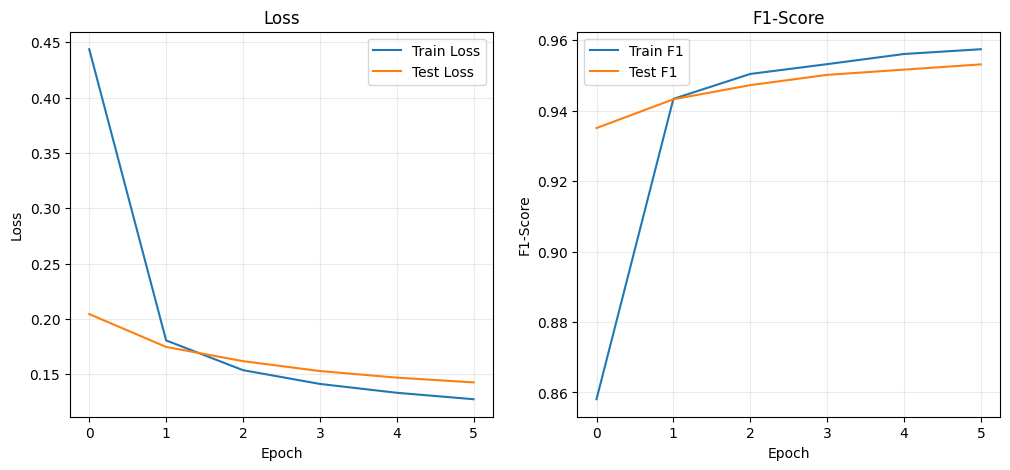

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_losses, label='Test Loss')

axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[0].grid(alpha=0.25)
axes[0].legend()

# F1
axes[1].plot(train_f1s, label='Train F1')
axes[1].plot(test_f1s, label='Test F1')

axes[1].set_title('F1-Score')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1-Score')

axes[1].grid(alpha=0.25)
axes[1].legend()

plt.show()

## Data

In [33]:
model.eval()

dl = DataLoader(test_dataset, batch_size=len(X_test))
X, y = next(iter(dl))
X, y = X.to(DEVICE), y.to(DEVICE)
with torch.no_grad():
    pred_logits = model(X)
    pred_labels = pred_logits.argmax(axis=1).cpu()

    news_embeds = model.embedding(X).mean(axis=1).cpu()

In [34]:
news_tsne = TSNE(n_components=2, perplexity=25).fit_transform(news_embeds)

In [35]:
labels = test_dataset.labels
labels

Index(['Интернет и СМИ', 'Культура', 'Спорт', 'Экономика'], dtype='object')

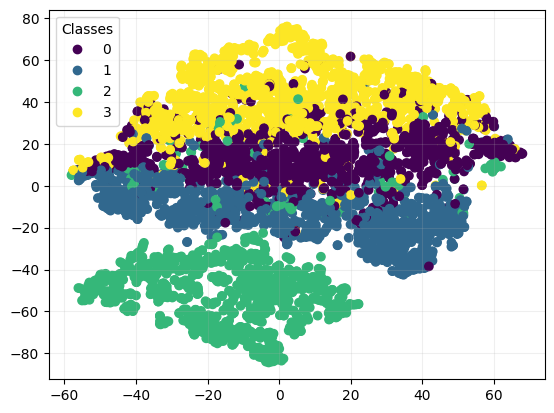

In [36]:
scatter = plt.scatter(news_tsne[:, 0], news_tsne[:, 1], c=pred_labels, label=labels)
plt.legend(*scatter.legend_elements(), title='Classes')
plt.grid(alpha=0.2)
plt.show()